In [ ]:
# pip install --upgrade mplfinance
# pip install yfinance
# pip install PyPortfolioOpt
# pip install --upgrade matplotlib
# pip install boto3
# pip install python-dotenv
# pip install pandas
# pip install numpy

SyntaxError: invalid syntax (3739551061.py, line 3)

In [3]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, expected_returns
import boto3
import io
import os
from dotenv import load_dotenv
import streamlit as st

load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
AWS_REGION = os.getenv('AWS_REGION')
PROCESSED_BUCKET = os.getenv('PROCESSED_BUCKET')

In [4]:
s3 = boto3.client('s3',
                  aws_access_key_id=AWS_ACCESS_KEY_ID,
                  aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                  region_name=AWS_REGION)

object_key = 'processed/latest_holdings.csv'

response = s3.get_object(Bucket=PROCESSED_BUCKET, Key=object_key)
content = response['Body'].read().decode('utf-8')

user_data = pd.read_csv(io.StringIO(content))

user_stocks = user_data['Stock'].tolist()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


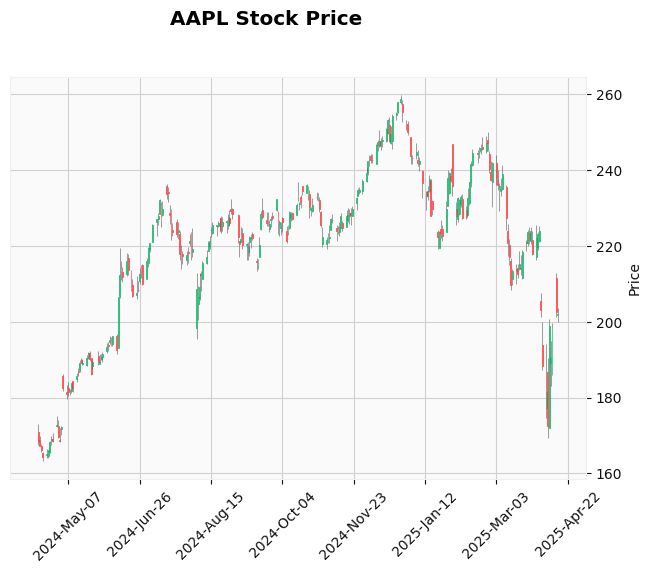

In [5]:
# historical data for specific ticker
def get_historical_data(ticker):
    stock_data = yf.download(ticker, start="2024-04-16", end="2025-04-16", group_by="ticker")
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = stock_data.columns.droplevel(0)
    return stock_data

stock = input('What ticker are you interested in seeing historical data for?').upper()

curr_stock = get_historical_data(str(stock))

expected_cols = ["Open", "High", "Low", "Close"]


curr_stock = curr_stock.dropna(subset=expected_cols)
mpf.plot(curr_stock, type="candle", volume=False, show_nontrading=True, 
         title=f"{stock} Stock Price", style="yahoo")


In [6]:
# stock efficiency
user_stocks = pd.Series(user_stocks).dropna().tolist()
user_stocks = [t.strip().upper() for t in user_stocks]

data = yf.download(user_stocks, period="1y")["Close"]

returns = expected_returns.mean_historical_return(data)
cov_matrix = risk_models.sample_cov(data)

ef = EfficientFrontier(returns, cov_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print(ef)
print(cleaned_weights)


[*********************100%***********************]  5 of 5 completed


OrderedDict([('AAPL', 0.32083), ('AMZN', 0.0), ('META', 0.0), ('NVDA', 0.0), ('TSLA', 0.67917)])


In [7]:
weights_df = pd.DataFrame.from_dict(cleaned_weights, orient='index', columns=['Weight'])
weights_df

,Weight
AAPL,0.32083
AMZN,0.00000
META,0.00000
NVDA,0.00000
TSLA,0.67917
